## Part 1 - Bootstraping

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from collections import defaultdict
from math import comb
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('framingham_heart_disease.csv')

### Section 1
Reminder from previous part:<br>
We would like to explore the relations between: Number of cigaretes per day (discrete), total cholesterol (continous), diaBP (diastolic BP) and sysBP (systolic BP - continous). <br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over sysBP**

Preparing the subset that we will work with, as done in part 3

In [3]:
df.dropna(subset=['cigsPerDay', 'totChol', 'diaBP', 'sysBP'], inplace=True)
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['sysBP']], test_size=0.9519115171916326, random_state=42)

#### section a - calculating confidence intervals based on the variance matrix and normal approximation 
Calculating the parameters

In [4]:
X = sm.add_constant(df_train)
model = sm.OLS(y_train,X)
model_res = model.fit()
model_res.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

In [5]:
# Since the variance is unknown we will compute it using the unbiased estimator as shown in tutorial 5
dof = len(df_train)-2
sigma_squared = np.dot(model_res.resid.to_numpy().T,model_res.resid.to_numpy())/(len(df_train)-4)
ci_t_percentile = norm().ppf(0.95)
C = np.linalg.inv(np.matmul(X.T,X))  # C = (X.T * X)^-1

In [6]:
normal_approx_cis = []
for i, beta in enumerate(model_res.params):
    normal_approx_cis.append((beta - ci_t_percentile*np.sqrt(sigma_squared*C[i,i]), beta + ci_t_percentile*np.sqrt(sigma_squared*C[i,i])))
    print(f"Confidence interval for beta_{i} is: [{beta - ci_t_percentile*np.sqrt(sigma_squared*C[i,i])},{beta + ci_t_percentile*np.sqrt(sigma_squared*C[i,i])}]")

Confidence interval for beta_0 is: [-20.120873608415245,6.530840172599772]
Confidence interval for beta_1 is: [-0.12499805793941654,0.12014199808401821]
Confidence interval for beta_2 is: [0.024470264676292097,0.08700841545378751]
Confidence interval for beta_3 is: [1.3755587622140237,1.6662906536246527]


#### section b - confidence intervals based on bootsrtap standart error

In [7]:
def cal_bootstrap_normal_se(B, df, features_cols, label_cols):
    df_len = len(df)
    num_param = len(df.columns)
    param_sum = np.zeros((num_param))
    param_sum2 = np.zeros((num_param))
    for i in range(B):
        boot_df = df.sample(replace=True, n=200)
        y = boot_df[label_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        param_sum = param_sum + model_res.params
        param_sum2 = param_sum2 + (model_res.params) ** 2
    return np.sqrt((1/B)*(param_sum2) - ((1/B)*(param_sum))**2)
        

In [8]:
bootstrap_se = cal_bootstrap_normal_se(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], label_cols=['sysBP'])

In [9]:
bootstrap_se_cis = []
for i, beta in enumerate(model_res.params):
    bootstrap_se_cis.append((beta - ci_t_percentile*bootstrap_se[i],beta + ci_t_percentile*bootstrap_se[i]))
    print(f"Confidence interval based on bootstrap s.e for beta_{i} is: [{beta - ci_t_percentile*bootstrap_se[i]},{beta + ci_t_percentile*bootstrap_se[i]}]")

Confidence interval based on bootstrap s.e for beta_0 is: [-23.53280577326919,9.942772337453718]
Confidence interval based on bootstrap s.e for beta_1 is: [-0.12787928954180927,0.12302322968641094]
Confidence interval based on bootstrap s.e for beta_2 is: [0.02254935818013573,0.08892932194994388]
Confidence interval based on bootstrap s.e for beta_3 is: [1.3434955249794076,1.6983538908592688]


#### section c - pivotals confidence intervals 

In [10]:
def cal_boot_pivot_quantile(B, df, features_cols, labels_cols, alpha):
    num_sample = len(df)
    q = 1 - alpha/2
    g_dict = defaultdict(list)
    q_list = [0] *(len(features_cols) + 1)
    # calculate the real sample param
    X = df[features_cols]
    X['const'] = np.ones((num_sample))
    X = X[['const', *features_cols]]
    Y = df[labels_cols]
    model = sm.OLS(Y, X)
    model_res = model.fit()
    b_r = model_res.params
    for i in range(B):
        new_df = df.sample(num_sample, replace=True)
        X = new_df[features_cols]
        X['const'] = np.ones((num_sample))
        X = X[['const', *features_cols]]
        Y = new_df[labels_cols]
        model = sm.OLS(Y, X)
        model_res = model.fit()
        for i in range(len(features_cols) + 1):
            g_dict[i].append((num_sample*0.5)*(model_res.params[i] - b_r[i]))
    for i in range(len(features_cols) + 1):
        q_list[i] = (np.quantile(g_dict[i], q), np.quantile(g_dict[i], alpha/2))
    return q_list

In [11]:
qunatiles_list = cal_boot_pivot_quantile(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'], alpha=0.05)

In [12]:
pivotal_cis = []
for i, beta in enumerate(model_res.params):
    pivotal_cis.append((beta - qunatiles_list[i][0]/np.sqrt(len(df_train)),beta - qunatiles_list[i][1]/np.sqrt(len(df_train))))
    print(f"Pivotal confidence intervals based on bootstrap for beta_{i} is: [{beta - qunatiles_list[i][0]/np.sqrt(len(df_train))},{beta - qunatiles_list[i][1]/np.sqrt(len(df_train))}]")

Pivotal confidence intervals based on bootstrap for beta_0 is: [-139.00101297416816,120.8337818435989]
Pivotal confidence intervals based on bootstrap for beta_1 is: [-0.9903568915846825,1.049659338734582]
Pivotal confidence intervals based on bootstrap for beta_2 is: [-0.24344487599770823,0.3687057186390451]
Pivotal confidence intervals based on bootstrap for beta_3 is: [0.15530943587611667,2.987101258079251]


### Section 2 - confidence intervals based on quantiles method

In [13]:
def cal_boot_quantile(B, df, features_cols, labels_cols, alpha):
    num_sample = len(df)
    q1 = 1 - (alpha / 2)
    q2 = alpha / 2
    g_dict = defaultdict(list)
    q_list = [0] * (len(features_cols) + 1)
    for i in range(B):
        new_df = df.sample(num_sample, replace=True)
        X = new_df[features_cols]
        X['const'] = np.ones((num_sample))
        X = X[['const', *features_cols]]
        Y = new_df[labels_cols]
        model = sm.OLS(Y, X)
        model_res = model.fit()
        for i in range(len(features_cols) + 1):
            g_dict[i].append(model_res.params[i])
    for i in range(len(features_cols) + 1):
        q_list[i] = (np.quantile(g_dict[i], q2), np.quantile(g_dict[i], q1))
    return q_list

In [14]:
confidence_intervals = cal_boot_quantile(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'], alpha=0.05)

In [15]:
qunatiles_cis = []
for i, ci in enumerate(confidence_intervals):
    qunatiles_cis.append((ci[0],ci[1]))
    print(f"Quantiles confidence intervals based on bootstrap for beta_{i} is: [{ci[0]},{ci[1]}]")

Quantiles confidence intervals based on bootstrap for beta_0 is: [-27.729335000310297,12.687567359276127]
Quantiles confidence intervals based on bootstrap for beta_1 is: [-0.1691959521500936,0.15796873893163083]
Quantiles confidence intervals based on bootstrap for beta_2 is: [0.015227570424309392,0.09885079914465027]
Quantiles confidence intervals based on bootstrap for beta_3 is: [1.3119316314917084,1.7491846360421812]


**Calculating the parameters using the whole dataset**

In [16]:
X = sm.add_constant(df[['cigsPerDay', 'totChol', 'diaBP']])
model = sm.OLS(df[['sysBP']],X)
model_res = model.fit()
model_res.params

const         5.611044
cigsPerDay   -0.082200
totChol       0.040282
diaBP         1.422623
dtype: float64

### Comparing the confidence intervals

In [17]:
ci_list = [normal_approx_cis, bootstrap_se_cis, pivotal_cis, qunatiles_cis]
ci_names = ['normal approx', 'bootstrap se', 'pivotal', 'qunatiles']
data_dict = {}
data_dict['beta_i'] = ['beta 0','beta 1','beta 2', 'beta 3']
for (name, li) in zip(ci_names, ci_list):
    data_dict[name+'_lower'] = [x[0] for x in li]
    data_dict[name+'_upper'] = [x[1] for x in li]
ci_df = pd.DataFrame(data_dict)

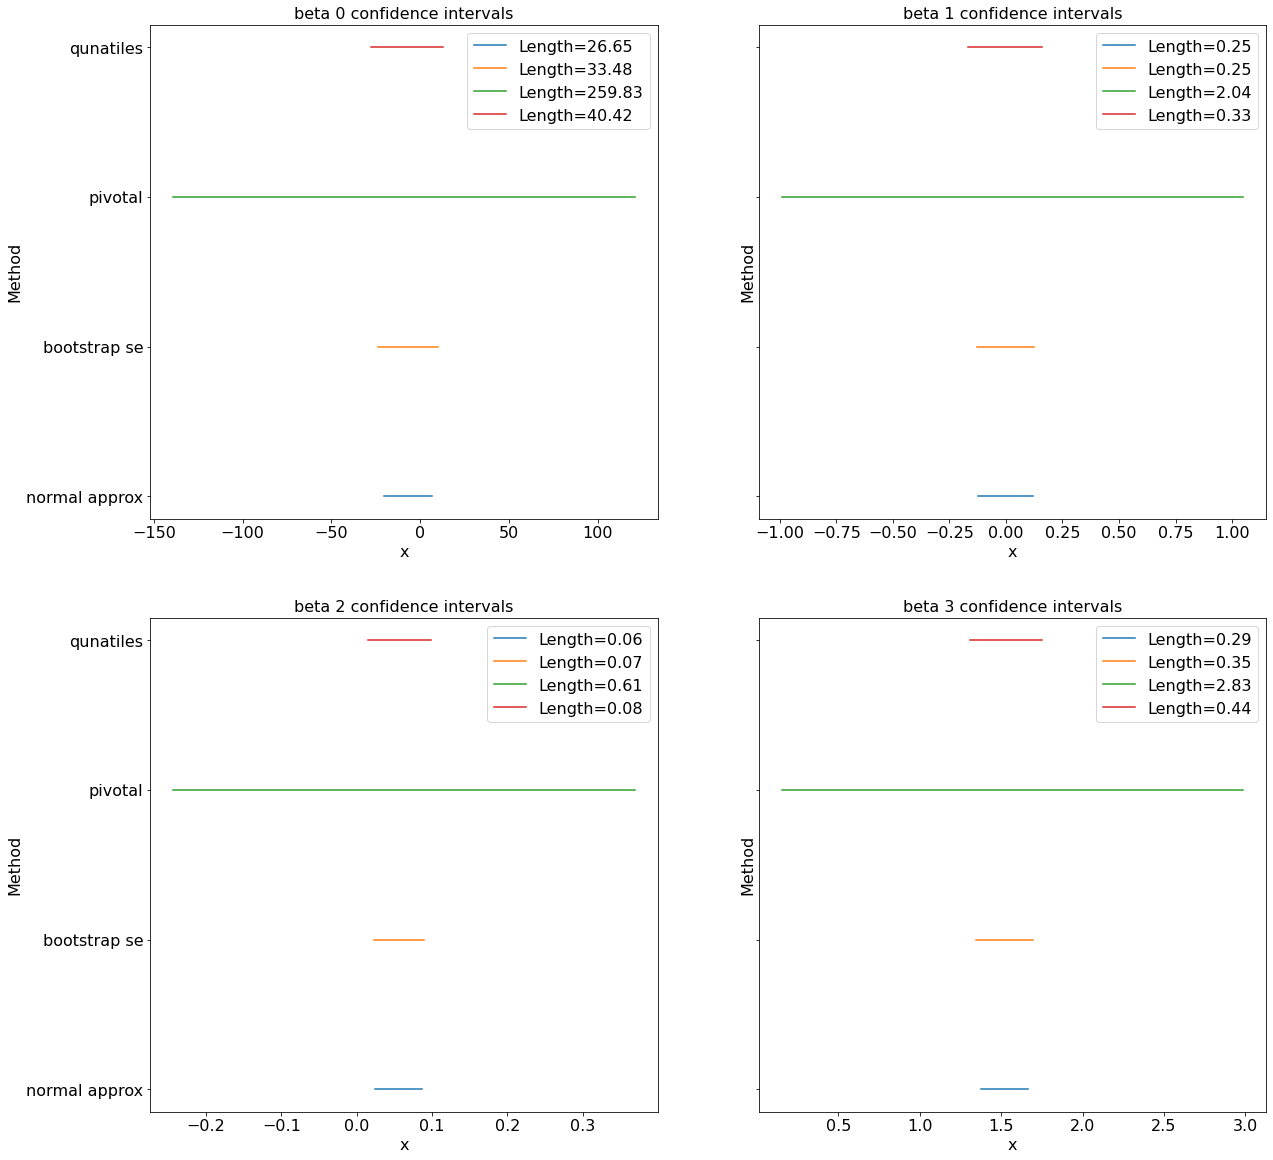

In [18]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(20,20))
row_idx = 0
col_idx = 0
for i, row in ci_df.iterrows():
    for y, ci_name in enumerate(ci_names):
        ax[row_idx][col_idx].plot((row[ci_name+'_lower'], row[ci_name+'_upper']), (y,y), label=f"Length={np.around(row[ci_name+'_upper']-row[ci_name+'_lower'],2)}")
    ax[row_idx][col_idx].set_title(row['beta_i'] + ' confidence intervals', fontsize=16)
    ax[row_idx][col_idx].set_xlabel('x', fontsize=16)
    ax[row_idx][col_idx].set_ylabel('Method', fontsize=16)
    ax[row_idx][col_idx].tick_params(axis='both', which='major', labelsize=16)
    ax[row_idx][col_idx].legend(fontsize=16)
    col_idx += 1
    if i%2:
        col_idx = 0
        row_idx += 1
plt.yticks(range(len(ci_names)),ci_names)
plt.show()

**Insights**:<br>
* First we notice that all of the parameters of the model that was trained on all dataset are in the confidence interval using all of the methods.
* As we can see the confidence interval based on the normal approximation yields the smallest interval for all of the parameters (as expected).
* The next smallest interval is the interval based on the se calculated using the bootstrap.
* In small gap behind the three, the interval calculated based on the quantiles (using bootstrap) is the third smallest.
* The largest interval was calculated based on the pivot method. We can see that the difference between this interval's length and all other intervals is significantly large, this might be due to the fact that the pivot method relies on estimating properly the distribution of the parmeters $\beta_i$. This also assumes that there is a distribution for those parameters. Both of those assumptions are very strong and seems like they do not hold.

### Section 3

#### Section a

In [19]:
X = sm.add_constant(df_train)
model = sm.OLS(y_train,X)
model_res = model.fit()
model_res.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

In [20]:
new_df = pd.concat([df_test, y_test], axis=1).sample(100)

In [21]:
y_test_100 = new_df[['sysBP']]
new_df = new_df[['cigsPerDay', 'totChol', 'diaBP']]

In [22]:
X = sm.add_constant(new_df)

In [23]:
y_new_preds = model_res.predict(X)

#### Section b + c

### Calculating confidence interval using bootstrap normal $\hat{S.E}$ approximation

In [24]:
def cal_bootstrap_normal_se_predict(B, df_train, X_test, features_cols, labels_cols):
    df_test_len = len(X_test)
    df_train_len = len(df_train)
    predict_sum = np.zeros((df_test_len))
    predict_sum2 = np.zeros((df_test_len))
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        y = boot_df[labels_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_train_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        predict_sum = predict_sum + model_res.predict(X_test)
        predict_sum2 = predict_sum2 + (model_res.predict(X_test)) ** 2
    return np.sqrt((1/B)*(predict_sum2) - ((1/B)*(predict_sum))**2)

In [25]:
y_preds_se = cal_bootstrap_normal_se_predict(400, pd.concat([df_train, y_train], axis=1),
                        X, features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'])

In [26]:
y_new_cis = [(y_pred - ci_t_percentile*y_pred_se, y_pred + ci_t_percentile*y_pred_se)
              for (y_pred, y_pred_se) in zip(y_new_preds, y_preds_se)]

In [27]:
sum([y_new_ci[0] < y_new[0] < y_new_ci[1] for (y_new, y_new_ci) in zip(y_test_100.values, y_new_cis)])/100

0.15

### Calculating confidence interval using quantiles method

In [28]:
def cal_bootstrap_quantile_predict(B, df_train, X_test, features_cols, labels_cols, alpha=0.05):
    df_test_len = len(X_test)
    df_train_len = len(df_train)
    q1 = alpha / 2
    q2 = 1 - q1
    predict_dict = defaultdict(list)
    q_list = [0] * (df_test_len)
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        y = boot_df[labels_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_train_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        pred = model_res.predict(X_test)
        for j in range(df_test_len):
            predict_dict[j].append(pred.iloc[j])
    for i in range(df_test_len):
        q_list[i] = (np.quantile(predict_dict[i], q1), np.quantile(predict_dict[i], q2))
    return q_list

In [29]:
y_pred_ci = cal_bootstrap_quantile_predict(400, pd.concat([df_train, y_train], axis=1),
                        X, features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'])

In [30]:
sum([y_new_ci[0] < y_new[0] < y_new_ci[1] for (y_new, y_new_ci) in zip(y_test_100.values, y_pred_ci)])/100

0.17

We can see that using both methods: qunatiles and normal S.E approximation using bootstrap gives us very poor confidence intervals for the predictions itself.<br>
The reason for this might be the fact that we calculated confidence intervals for the expected prediction, which doesn't take into account the residuals of the model.

#### Section d

We seen in class that the confident interval for the $Y_{new}$ is $[\hat{Y_{new}}\pm z_{1-\frac{\alpha}{2}}\hat{\sigma_{\epsilon}}\sqrt{1+X_{new}^T(X^TX)^{-1}X_{new}}]$. The idea behind this modification in the confident interval is that we adding the estimator of the variance of the data to the variance of our model, which make the confident interval longer. So if we want to build a confident interval base of Bootstrap, we would make a small modification in our current Bootstrap confident interval : $[\hat{Y^i}_{new}\pm z_{\frac{\alpha}{2}}\hat{S.E}_{bootstrap}], \ when \ \hat{S.E}_{bootstrap}^2=\underbrace{\frac{1}{B}\sum_{j=1}^{B}\hat{(Y^j)^2}_{new}-\frac{1}{B}(\sum_{j=1}^{B}\hat{(Y^j)}_{new})^2 }_{variance \ of \ the \ model}+\underbrace{\frac{1}{B}\sum_{j=1}^{B}\hat{\sigma^2_j}_{\epsilon}}_{estimator \ to \ the \ model \ variance} $  

## Part 2 

In [31]:
df = pd.read_csv('framingham_heart_disease.csv')
df.dropna(subset=['BMI', 'male'], inplace=True)

### Section 1: Hypothesis question:

Let's denote $BMI_{male}$ as the BMI of a random male and $BMI_{female}$ as the BMI of a random female.<br> Our Hypothesis question is : does BMI of a male is sthochsticly greeter then BMI of a female i.e : $BMI_{male} \ \succ BMI_{female}$

Text(0.5, 1.0, 'Female')

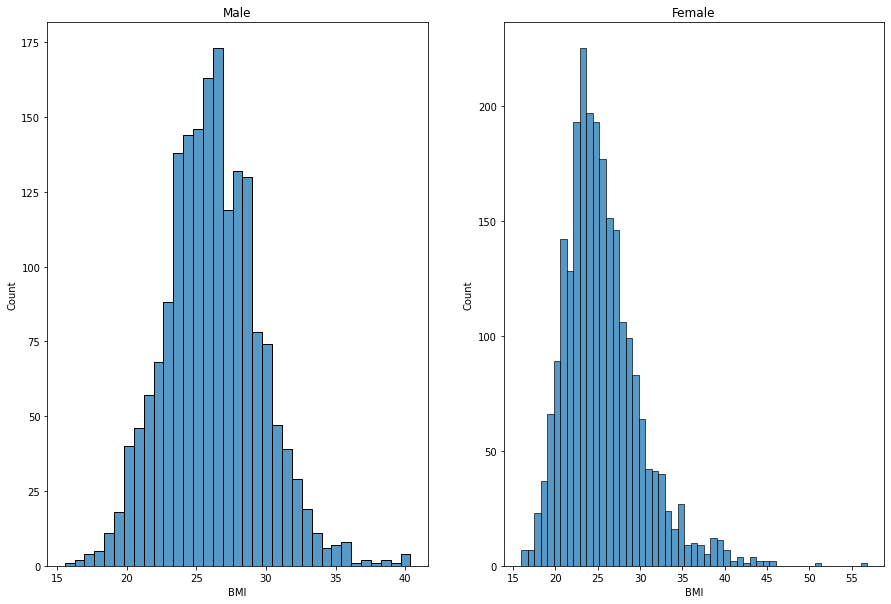

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.histplot(data=df[df['male']== 1], x='BMI', ax=axes[0]).set_title('Male')
sns.histplot(data=df[df['male']== 0], x='BMI', ax=axes[1]).set_title('Female')

From first look on the histogram we can infer that the answer to our hypothesis question is true.

### section 2

In [192]:
male_train, male_test, bmi_train, bmi_test = train_test_split(df[['male']], df[['BMI']], test_size=4019/4219, random_state=42)

### section 3

**Estimating $\mu_1,\ \mu_2 \ and \ \delta=\mu_1-\mu_2$**

In [193]:
bmi_train = pd.concat([male_train, bmi_train], axis=1)

In [194]:
male_bmi = bmi_train[bmi_train["male"] == 1]["BMI"]
female_bmi = bmi_train[bmi_train["male"] == 0]["BMI"]

In [195]:
male_bmi_avg = male_bmi.mean()
female_bmi_avg = female_bmi.mean()

In [38]:
print(f"The average BMI of males is: {np.around(male_bmi_avg, 2)}, The average BMI of females is {np.around(female_bmi_avg, 2)}")

The average BMI of males is: 26.34, The average BMI of females is 25.9


In [39]:
print(f"The estimation of delta is: {np.around(male_bmi_avg - female_bmi_avg, 2)}")

The estimation of delta is: 0.43


Our estimators here for all three varibales: $\mu_1,\ \mu_2 \ and \ \delta=\mu_1-\mu_2$, are MLEs since the estimators for the mean of BMIs are MLEs to the expectation and using the equivariance of MLE we get that the estimator for $\delta$ is MLE as well.

#### Section b

In [40]:
def cal_bootstrap_quantile_delta_bmi(B, df_train, alpha=0.05):
    df_train_len = len(df_train)
    q1 = alpha / 2
    q2 = 1 - q1
    q_list = []
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        boot_df_male = boot_df[boot_df["male"] == 1]
        boot_df_female = boot_df[boot_df["male"] == 0]
        male_bmi_avg = boot_df_male.BMI.mean()
        female_bmi_avg = boot_df_female.BMI.mean()
        delta = male_bmi_avg - female_bmi_avg
        q_list.append(delta)
    return (np.quantile(q_list, q1), np.quantile(q_list, q2))

In [41]:
delta_bmi_ci = cal_bootstrap_quantile_delta_bmi(400, bmi_train, alpha=0.05)
print(f"The confidence interval for delta using quantiles bootstrap method is: [{np.around(delta_bmi_ci[0], 2)},{np.around(delta_bmi_ci[1], 2)} ]")

The confidence interval for delta using quantiles bootstrap method is: [-0.61,1.52 ]


#### Section c

In [42]:
male_all_bmi = df[df["male"] == 1]["BMI"]
female_all_bmi = df[df["male"] == 0]["BMI"]

In [43]:
print(f"Delta estimation using the whole df: {np.around(male_all_bmi.mean() - female_all_bmi.mean(), 2)}")

Delta estimation using the whole df: 0.67


As we can see, the stimator for $\delta$ using the whole dataset is inside the confidence interval for $\delta$ based on the quantiles bootstrap method using 200 samples.

####  Section d

Wald test :<br>          $H_0 \ \mu_1=\mu_2$          <br>$H_0 \ \mu_1\ne\mu_2$          <br>T.S:$\frac{|\mu_1-\mu_2|}{\hat{s.e}}$

In [44]:
test_var = ((male_bmi.std())**2/len(male_bmi)) + ((female_bmi.std())**2/len(female_bmi))
test_stat = abs(male_bmi_avg - female_bmi_avg) / (test_var)**0.5
pval_wald = 2*norm.cdf(-test_stat)

In [46]:
print(f"The p-value for the wald test is: {np.around(pval_wald, 2)}")

The p-value for the wald test is: 0.44


Permutation Test:<br>$H_0:BMI_{male} \ = BMI_{female}$<br> $H_1:BMI_{male} \ \succ BMI_{female}$<br>T.S:$\mu_{male}-\mu_{female}$<br>$Pvalue=\frac{\#\mathbb{1}\{T_j>=T_0\}}{{n+m \choose n}}$. <br>Because the samples here are too big to compute the p-value of the Permutation Test, will use Bootstrap to calculate the p-value :First we'll calcualte the statistic of our samples (S) : $\delta^S={\mu^S}_{male}-{\mu^S}_{female}$. <br>Then for each bootstrap iteration we'll randmoly permuate the data and calculate the statistic accordingly, we'll denote this current i'th bootstrap iteration statistic by $\delta^S_i={\mu^S_i}_{male}-{\mu^S_i}_{female}$. <br>
Then our P-value will be: $Pvalue=\frac{\#\mathbb{1}\{\delta^S_i>=\delta^S_0\}}{B}$

In [51]:
def bootstrap_permutation_pval(B, df, perm_test_stat):
    pval_perm = 0
    counter = 0
    male_len = len(df[df["male"] == 1]["BMI"])
    for i in range(B):
        male_df = df.sample(male_len)
        male_index = [int(i) for i in male_df.index]
        female_df = df.drop(male_index, axis=0)
        delta = male_df["BMI"].mean() - female_df["BMI"].mean()
        if delta >= perm_test_stat:
            counter += 1
    return counter/B

In [52]:
original_delta = male_bmi_avg - female_bmi_avg
pval = bootstrap_permutation_pval(2000, bmi_train, original_delta)

In [53]:
print(f"The p-value for the permutation test based on bootstrap is: {np.around(pval, 2)}")

The p-value for the permutation test based on bootstrap is: 0.24


### Section 4

#### Section a

In [57]:
male_median = male_bmi.median()
female_median = female_bmi.median()

In [58]:
print(f"The median BMI of males is: {np.around(male_median, 2)}, The median BMI of females is {np.around(female_median, 2)}")

The median BMI of males is: 26.02, The median BMI of females is 25.06


In [59]:
print(f"The estimation of delta is: {np.around(male_median - female_median, 2)}")

The estimation of delta is: 0.96


As we can see from the histograms of both males and females, it is quite safe to assume that the data of their BMI has normal distribution. Since the normal distribution is symmetric around the mean, we know that the median should be equal to the mean. Now, our estimators for the median is not being calculated the same way as the mean so this is not an MLE for the median.

#### Section b

In [61]:
def cal_bootstrap_quantile_delta_bmi(B, df_train, alpha=0.05):
    df_train_len = len(df_train)
    q1 = alpha / 2
    q2 = 1 - q1
    q_list = []
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        boot_df_male = boot_df[boot_df["male"] == 1]
        boot_df_female = boot_df[boot_df["male"] == 0]
        male_bmi_median = boot_df_male.BMI.median()
        female_bmi_median = boot_df_female.BMI.median()
        delta = male_bmi_median - female_bmi_median
        q_list.append(delta)
    return (np.quantile(q_list, q1), np.quantile(q_list, q2))

In [62]:
delta_bmi_ci = cal_bootstrap_quantile_delta_bmi(400, bmi_train, alpha=0.05)
print(f"The confidence interval for delta using quantiles bootstrap method is: [{np.around(delta_bmi_ci[0], 2)},{np.around(delta_bmi_ci[1], 2)} ]")

The confidence interval for delta using quantiles bootstrap method is: [-0.53,2.01 ]


#### Section c

In [63]:
male_all_bmi = df[df["male"] == 1]["BMI"]
female_all_bmi = df[df["male"] == 0]["BMI"]

In [64]:
print(f"Delta estimation using the whole df: {np.around(male_all_bmi.median() - female_all_bmi.median(), 2)}")

Delta estimation using the whole df: 1.34


As we can see, the stimator for $\delta$ using the whole dataset is inside the confidence interval for $\delta$ based on the quantiles bootstrap method using 200 samples.

#### Section d

Permutation Test:<br>$H_0:BMI_{male} \ = BMI_{female}$<br> $H_1:BMI_{male} \ \succ BMI_{female}$<br>T.S:$\mu_{male}-\mu_{female}$<br>$Pvalue=\frac{\#\mathbb{1}\{T_j>=T_0\}}{{n+m \choose n}}$. <br>Because the samples here are too big to compute the p-value of the Permutation Test, will use Bootstrap to calculate the p-value :First we'll calcualte the statistic of our samples (S) : $\delta^S={\mu^S}_{male}-{\mu^S}_{female}$. <br>Then for each bootstrap iteration we'll randmoly permuate the data and calculate the statistic accordingly, we'll denote this current i'th bootstrap iteration statistic by $\delta^S_i={\mu^S_i}_{male}-{\mu^S_i}_{female}$. <br>
Then our P-value will be: $Pvalue=\frac{\#\mathbb{1}\{\delta^S_i>=\delta^S_0\}}{B}$

In [68]:
def bootstrap_permutation_pval(B, df, perm_test_stat):
    pval_perm = 0
    counter = 0
    male_len = len(df[df["male"] == 1]["BMI"])
    for i in range(B):
        male_df = df.sample(male_len)
        male_index = [int(i) for i in male_df.index]
        female_df = df.drop(male_index, axis=0)
        delta = male_df["BMI"].median() - female_df["BMI"].median()
        if delta >= perm_test_stat:
            counter += 1
    return counter/B

In [69]:
original_delta = male_median - female_median
pval = bootstrap_permutation_pval(2000, bmi_train, original_delta)

In [70]:
print(f"The p-value for the permutation test based on bootstrap is: {np.around(pval, 2)}")

The p-value for the permutation test based on bootstrap is: 0.08


#### Section e

Wald test assumes that our parameter of interest is asymptotically normal, since our estimator is not an MLE we cannot say for sure that it is asymptotically normal, so the results of Wald test would be ambigous.<br>
T-test however, assumes normal distribution over our parameter of interest and we cannot say for sure that the median is normally distributed.

### Section 5

In [196]:
bmi_train['ranked_bmi'] = bmi_train[['BMI']].rank(method='first')

In [197]:
sum_df = bmi_train.groupby('male').sum().reset_index()
S1 = sum_df[sum_df['male'] == 1]['ranked_bmi']

In [198]:
S1

1    9563.0
Name: ranked_bmi, dtype: float64

We will use the normal approximation for permuation tests since we have enough samples and because the BMI values are continous, thus we can assume that the sum of the ranks is normaly distributed in approximation.

In [199]:
expected_ranks = len(male_bmi)*(1 + len(bmi_train))/2

In [200]:
m = len(female_bmi)
n = len(male_bmi)
N = len(bmi_train)

In [201]:
var_bmi_part_1 = (n*m/(12*N*(N-1)))
var_bmi_part_2 = N*(N**2 -1)

In [204]:
count_rank_df = bmi_train.groupby('BMI')['ranked_bmi'].agg(['mean', 'count']).reset_index()

In [223]:
var_bmi_part_3 = 0
for (i, row) in count_rank_df[count_rank_df['count'] > 1].iterrows():
    t_r = row['count']
    if t_r == 81:
        t_r = 81.333
    var_bmi_part_3 += t_r * (t_r**2 -1)

In [224]:
var_ranks = var_bmi_part_1*(var_bmi_part_2 - var_bmi_part_3)

In [234]:
T = (S1.iloc[0] - expected_ranks)/np.sqrt(var_ranks)

In [236]:
Pval = 1 - norm.cdf(T)

In [239]:
print(f"The p-value for manh-whiteny-wilcoxon test with ties and normal approximation is: {np.around(Pval, 2)}")

The p-value for manh-whiteny-wilcoxon test with ties and normal approximation is: 0.04


In [246]:
def bootstrap_permutation_pval_ranks(B, count_rank_df, perm_test_stat, male_len):
    pval_perm = 0
    counter = 0
    for i in range(B):
        random_S1 = count_rank_df['mean'].sample(male_len, replace=True).sum()
        if random_S1 >= perm_test_stat:
            counter += 1
    return counter/B

In [253]:
male_len = len(male_bmi)
bootstrap_pval = bootstrap_permutation_pval_ranks(20000, count_rank_df, S1.iloc[0], male_len)

In [254]:
print(f"The p-value for manh-whiteny-wilcoxon test with ties using bootstrap is: {np.around(bootstrap_pval, 2)}")

The p-value for manh-whiteny-wilcoxon test with ties using bootstrap is: 0.14


### Section 6